## Catalog Exploration for 1 Week Data


A more condensed version from Catalog_Exploration notebook (basic parts are deleted for simplicity)

In [1]:
from obspy import read_events

In [2]:
catalog = read_events("hyp_koeri_2020.out")

/home/ege/miniconda3/envs/dsml/lib/python3.12/site-packages/obspy/io/nordic/utils.py:184: UserWarning: Lines of type I have not been implemented yet, please submit a development request
  warnings.warn("Lines of type %s have not been implemented yet, "


In [3]:
catalog

789 Event(s) in Catalog:
2020-01-01T19:01:54.900000Z | +40.820,  +28.930 | 2.1  ML
2020-01-02T04:57:48.500000Z | +40.635,  +29.132 | 2.0  ML
...
2020-09-29T07:11:43.000000Z | +40.843,  +28.184 | 1.7  ML
2020-09-30T11:17:58.200000Z | +40.532,  +29.245 | 1.4  ML
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [4]:
catalog[0].picks

[Pick
	     resource_id: ResourceIdentifier(id="smi:local/4a80d49b-55ce-4afb-9abc-dbdacc16375d")
	            time: UTCDateTime(2020, 1, 1, 19, 1, 58, 800000)
	     waveform_id: WaveformStreamID(network_code='', station_code='BRGA', channel_code='')
	      phase_hint: 'IAML'
	 evaluation_mode: 'manual',
 Pick
	     resource_id: ResourceIdentifier(id="smi:local/62dbc00d-279d-421d-b050-cac4e868c948")
	            time: UTCDateTime(2020, 1, 1, 19, 2, 1)
	     waveform_id: WaveformStreamID(network_code='', station_code='BRGA', channel_code='')
	      phase_hint: 'IAML'
	 evaluation_mode: 'manual',
 Pick
	     resource_id: ResourceIdentifier(id="smi:local/431598b4-4e17-45fd-ac51-f0968d7cf627")
	            time: UTCDateTime(2020, 1, 1, 19, 1, 58, 800000)
	     waveform_id: WaveformStreamID(network_code='', station_code='HYBA', channel_code='')
	      phase_hint: 'IAML'
	 evaluation_mode: 'manual',
 Pick
	     resource_id: ResourceIdentifier(id="smi:local/667edb1a-017f-47cc-8115-178b693ebd92

In [5]:
events_data = []
for event in catalog:
    origin = event.preferred_origin() or event.origins[0] if event.origins else None
    magnitude = event.preferred_magnitude() or event.magnitudes[0] if event.magnitudes else None
    
    if origin:
        events_data.append({
            'datetime': origin.time.datetime if origin.time else None,
            'latitude': origin.latitude,
            'longitude': origin.longitude,
            'depth': origin.depth / 1000 if origin.depth is not None else None,  # Convert m to km
            'magnitude_type': magnitude.magnitude_type if magnitude else None,
            'magnitude': magnitude.mag if magnitude else None
        })

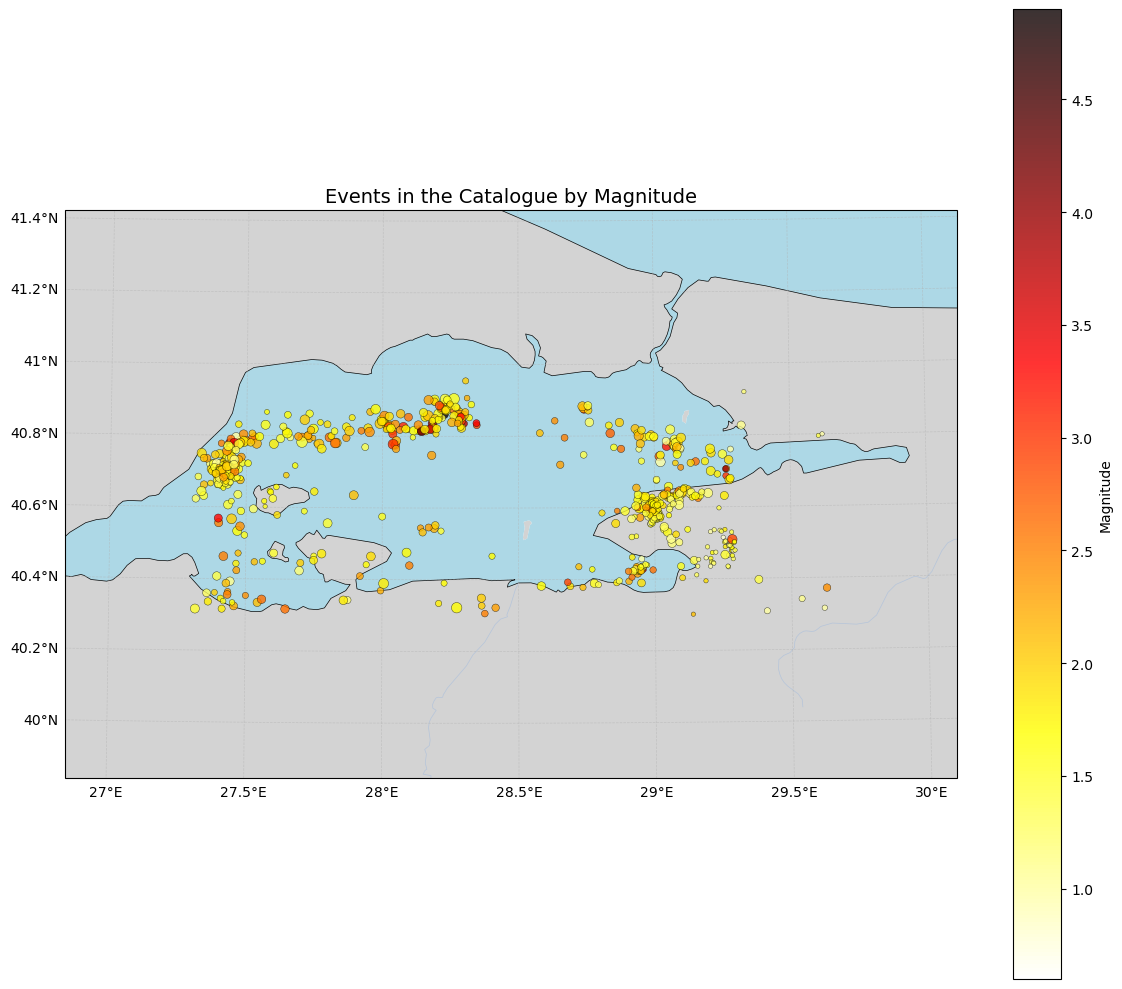

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

fig = plt.figure(figsize=(12, 10))

lats = [event.origins[0].latitude for event in catalog]
lons = [event.origins[0].longitude for event in catalog]

#Create local projection
center_lat = np.mean(lats)
center_lon = np.mean(lons)
projection = ccrs.NearsidePerspective(
    central_longitude=center_lon,
    central_latitude=center_lat,
    satellite_height=3000000.0  #Reduce height for more zoom
)

#Create map axes with the projection
ax = fig.add_subplot(1, 1, 1, projection=projection)

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.5, alpha=0.5)

#Get depths and magnitudes
depths = [event.origins[0].depth/1000 if event.origins[0].depth else 0 for event in catalog]
magnitudes = []
for event in catalog:
    if event.magnitudes:
        magnitudes.append(event.magnitudes[0].mag)
    else:
        magnitudes.append(0)

marker_sizes = [max(10, d * 2 + 10) for d in depths]  # Deeper = larger marker

scatter = ax.scatter(
    lons, lats,
    transform=ccrs.PlateCarree(),  #Input coordinates are lat/lon
    c=magnitudes,
    s=marker_sizes,
    cmap='hot_r',  #Reverse hot colormap: white for low, red/yellow for high
    alpha=0.8,
    zorder=5,
    edgecolor='k',
    linewidth=0.3
)

cbar = plt.colorbar(scatter, ax=ax, pad=0.05)
cbar.set_label('Magnitude')

lat_range = max(lats) - min(lats)
lon_range = max(lons) - min(lons)
padding = max(lat_range, lon_range) * 0.2  #Reduce padding for zoom
ax.set_extent(
    [min(lons) - padding, max(lons) + padding, 
     min(lats) - padding, max(lats) + padding],
    crs=ccrs.PlateCarree()
)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False  

plt.title('Events in the Catalogue by Magnitude', fontsize=14)

plt.tight_layout()
plt.show()

### Example Event from Catalog

In [7]:
event_0 = catalog[0]
event_0

Event:	2020-01-01T19:01:54.900000Z | +40.820,  +28.930 | 2.1  ML

	            resource_id: ResourceIdentifier(id="smi:local/361d9ef4-bb9a-4d10-95d9-2f1da880fead")
	             event_type: 'earthquake'
	   event_type_certainty: 'known'
	          creation_info: CreationInfo(agency_id='')
	    preferred_origin_id: ResourceIdentifier(id="smi:local/9b7bf8ad-0772-437a-a210-d0bec4a45ed1")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:local/7fa0daf5-50c4-43b2-b5a3-60e5fd6f7ece")
	                   ---------
	     event_descriptions: 1 Elements
	               comments: 1 Elements
	                  picks: 21 Elements
	             amplitudes: 21 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements

In [8]:
origin_0 = event_0.preferred_origin()
origin_0

Origin
	   resource_id: ResourceIdentifier(id="smi:local/9b7bf8ad-0772-437a-a210-d0bec4a45ed1")
	          time: UTCDateTime(2020, 1, 1, 19, 1, 54, 900000)
	     longitude: 28.9303
	      latitude: 40.8197
	         depth: 13100.0
	       quality: OriginQuality(used_station_count=17, standard_error=0.15, azimuthal_gap=88.0)
	 creation_info: CreationInfo(agency_id='')

In [9]:
origin_0.time

2020-01-01T19:01:54.900000Z

In [10]:
origin_0.time.datetime

datetime.datetime(2020, 1, 1, 19, 1, 54, 900000)

In [11]:
event_0.picks

[Pick
	     resource_id: ResourceIdentifier(id="smi:local/4a80d49b-55ce-4afb-9abc-dbdacc16375d")
	            time: UTCDateTime(2020, 1, 1, 19, 1, 58, 800000)
	     waveform_id: WaveformStreamID(network_code='', station_code='BRGA', channel_code='')
	      phase_hint: 'IAML'
	 evaluation_mode: 'manual',
 Pick
	     resource_id: ResourceIdentifier(id="smi:local/62dbc00d-279d-421d-b050-cac4e868c948")
	            time: UTCDateTime(2020, 1, 1, 19, 2, 1)
	     waveform_id: WaveformStreamID(network_code='', station_code='BRGA', channel_code='')
	      phase_hint: 'IAML'
	 evaluation_mode: 'manual',
 Pick
	     resource_id: ResourceIdentifier(id="smi:local/431598b4-4e17-45fd-ac51-f0968d7cf627")
	            time: UTCDateTime(2020, 1, 1, 19, 1, 58, 800000)
	     waveform_id: WaveformStreamID(network_code='', station_code='HYBA', channel_code='')
	      phase_hint: 'IAML'
	 evaluation_mode: 'manual',
 Pick
	     resource_id: ResourceIdentifier(id="smi:local/667edb1a-017f-47cc-8115-178b693ebd92

In [12]:
pick_00 =event_0.picks[0]
pick_00

Pick
	     resource_id: ResourceIdentifier(id="smi:local/4a80d49b-55ce-4afb-9abc-dbdacc16375d")
	            time: UTCDateTime(2020, 1, 1, 19, 1, 58, 800000)
	     waveform_id: WaveformStreamID(network_code='', station_code='BRGA', channel_code='')
	      phase_hint: 'IAML'
	 evaluation_mode: 'manual'

In [13]:
pick_00.waveform_id.station_code

'BRGA'

In [14]:
from catalog2csv import cat2csv
input_file = "hyp_koeri_2020.out"  
events_output = "earthquake_events_1week.csv"
stations_output = "station_arrivals_1week.csv"

cat2csv(input_file, events_output, stations_output)

Reading catalog from hyp_koeri_2020.out...


/home/ege/miniconda3/envs/dsml/lib/python3.12/site-packages/obspy/io/nordic/utils.py:184: UserWarning: Lines of type I have not been implemented yet, please submit a development request
  warnings.warn("Lines of type %s have not been implemented yet, "


Successfully read 789 events from catalog
Events written to earthquake_events_1week.csv
Station information written to station_arrivals_1week.csv (first arrival only)


In [15]:
import pandas as pd
events_df = pd.read_csv("earthquake_events.csv",parse_dates=['datetime'])
events_df

,datetime,latitude,longitude,depth,magnitude_type,magnitude
0,2020-01-01 19:01:54.900,40.8197,28.9303,13.1,ML,2.1
1,2020-01-02 04:57:48.500,40.6353,29.1317,7.0,ML,2.0
2,2020-01-02 11:18:40.900,40.8308,28.3470,7.5,ML,2.9
3,2020-01-02 18:58:53.200,40.7002,29.2073,16.4,ML,1.8
4,2020-01-03 00:39:11.700,40.8820,28.2262,10.0,ML,1.6
...,...,...,...,...,...,...
784,2020-09-27 00:58:42.300,40.8212,28.1990,12.0,ML,1.8
785,2020-09-27 22:54:36.200,40.5463,27.4783,14.5,ML,2.4
786,2020-09-29 04:52:59.400,40.7453,27.3847,10.7,ML,2.0
787,2020-09-29 07:11:43.000,40.8432,28.1837,6.5,ML,1.7


In [16]:
arrival_df = pd.read_csv("station_arrivals.csv",parse_dates=['datetime', 'arrival_time'])
arrival_df

,datetime,station_name,phase,arrival_time,amplitude,period
0,2020-01-01 19:01:54.900,BRGA,IAML,2020-01-01 19:01:58.800,8.600000e-09,NaN
1,2020-01-01 19:01:54.900,HYBA,IAML,2020-01-01 19:01:58.800,8.600000e-09,NaN
2,2020-01-01 19:01:54.900,BUYA,IAML,2020-01-01 19:01:59.100,8.600000e-09,NaN
3,2020-01-01 19:01:54.900,TUZL,IAML,2020-01-01 19:02:00.600,8.600000e-09,NaN
4,2020-01-01 19:01:54.900,ARMT,IAML,2020-01-01 19:02:00.900,8.600000e-09,NaN
...,...,...,...,...,...,...
14605,2020-09-29 07:11:43.000,YAYO,IAML,2020-09-29 07:12:10.800,1.000000e-10,NaN
14606,2020-09-30 11:17:58.200,GEML,IAML,2020-09-30 11:17:59.900,1.400000e-09,NaN
14607,2020-09-30 11:17:58.200,ARMT,IAML,2020-09-30 11:18:04.900,1.400000e-09,NaN
14608,2020-09-30 11:17:58.200,SUSR,IAML,2020-09-30 11:18:19.900,1.400000e-09,NaN


In [17]:
events_df["datetime"]

0     2020-01-01 19:01:54.900
1     2020-01-02 04:57:48.500
2     2020-01-02 11:18:40.900
3     2020-01-02 18:58:53.200
4     2020-01-03 00:39:11.700
                ...          
784   2020-09-27 00:58:42.300
785   2020-09-27 22:54:36.200
786   2020-09-29 04:52:59.400
787   2020-09-29 07:11:43.000
788   2020-09-30 11:17:58.200
Name: datetime, Length: 789, dtype: datetime64[ns]

## Statistics for Station and Date Selection Process

Since our catalog encompasses a large date range, I want to look at some statistics to determine a good time interval for waveforms and stations. 

/home/ege/rawcovar/catalog_implementation/catalog_stats.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['period_start'] = df_filtered['datetime'].dt.to_period(period).apply(lambda r: r.start_time)


Event Frequency Analysis (Magnitude >= 1.0, 2W Period):

Top 10 Most Active Periods:
   period_start  event_count  mean_magnitude  max_magnitude
36   2020-09-07           80        1.868750            4.6
1    2020-01-06           72        1.652778            4.9
48   2020-11-30           51        1.656863            3.3
47   2020-11-23           49        1.746939            3.0
49   2020-12-07           32        1.806250            3.1
46   2020-11-16           31        1.970968            3.5
50   2020-12-14           27        1.840741            2.8
43   2020-10-26           22        1.522727            2.3
42   2020-10-19           19        1.752632            2.8
41   2020-10-12           19        1.784211            3.2

Top Active Period:
period_start      2020-09-07 00:00:00
event_count                        80
mean_magnitude                1.86875
max_magnitude                     4.6
Name: 36, dtype: object


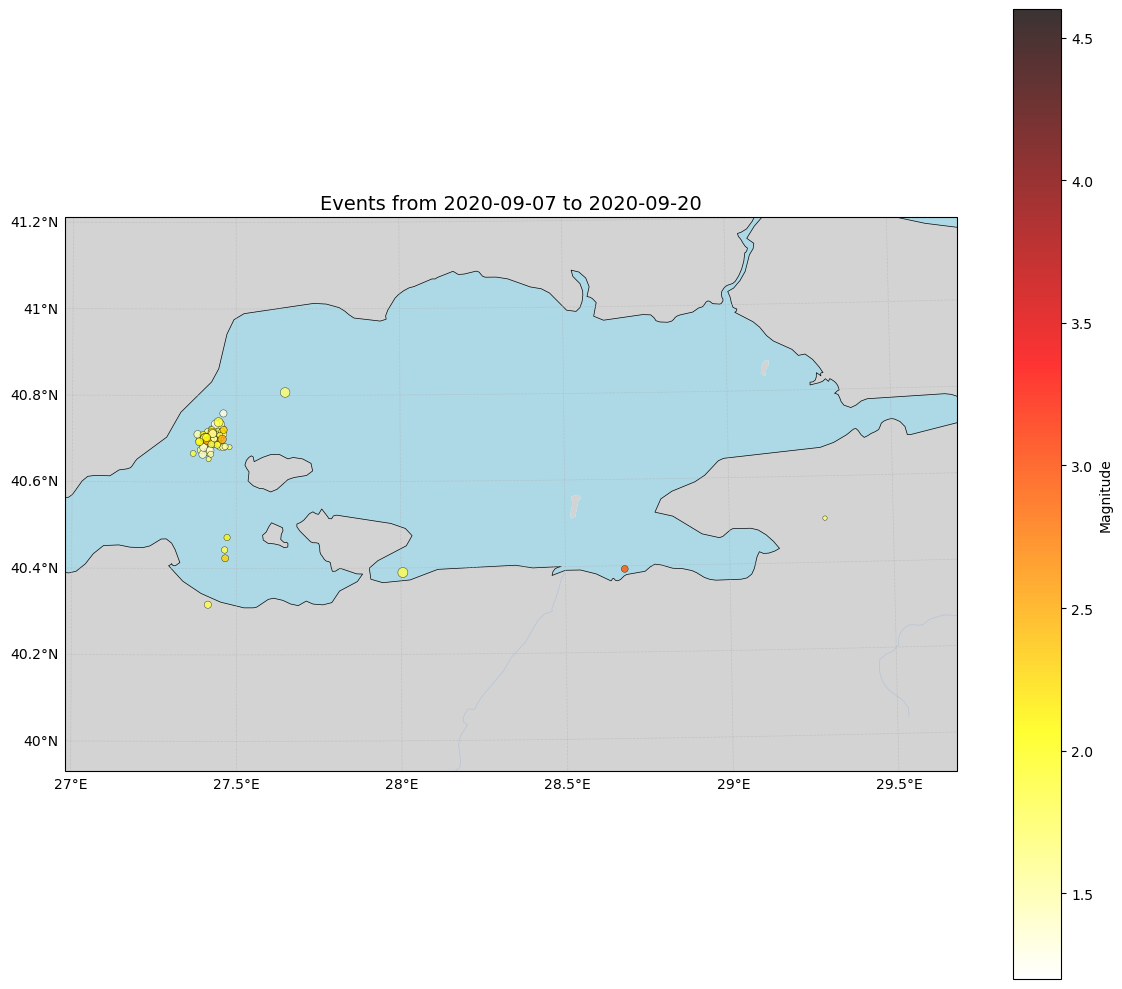


Station Arrival Analysis for Top Period:

Top 10 Stations by Number of Arrivals:
  station_name  arrival_count
0         GAZK             82
1         KRBG             81
2         MRMT             77
3          EDC             76
4         ERIK             63
5          RKY             63
6         BIGA             61
7         CANM             61
8         GELI             58
9          ALN             55

Top 10 Stations Magnitude Coverage:
   station_name  count  min  max      mean
24         GAZK     82  1.2  4.6  1.868293
42         KRBG     81  1.2  4.6  1.883951
44         MRMT     77  1.2  4.6  1.874026
17          EDC     76  1.2  4.6  1.909211
48          RKY     63  1.2  4.6  1.936508
20         ERIK     63  1.2  4.6  1.941270
6          BIGA     61  1.4  4.6  1.981967
10         CANM     61  1.2  4.6  1.954098
25         GELI     58  1.2  4.6  1.965517
1           ALN     55  1.2  4.6  1.936364


In [20]:
from catalog_stats import filtered_cat_summary
filtered_cat_summary(event_df=events_df, station_df=arrival_df, min_mag=1.0, prd="2W")

Good candidate for monthly period: KRBG and GAZK for 09-2020 

Good candidate for daily period: KRBG and MRMT for 11-01-2020 and KRBG and GAZK and MRMT for 09-09-2020

## Filtering Station Arrivals

In [20]:
import pandas as pd
df = pd.read_csv('station_arrivals.csv')

df['arrival_time'] = pd.to_datetime(df['arrival_time'])

start_date = '2020-09-01'
end_date = '2020-09-14'

krbg_sept_2020 = df[(df['station_name'] == 'KRBG') & (df['arrival_time'] >= start_date) & (df['arrival_time'] <= end_date)]

gazk_sept_2020 = df[(df['station_name'] == 'GAZK') & (df['arrival_time'] >= start_date) & (df['arrival_time'] <= end_date)]

krbg_sept_2020.to_csv('KRBG_01-09-2020_14-09-2020.csv', index=False)
gazk_sept_2020.to_csv('GAZK_01-09-2020_14-09-2020.csv', index=False)